In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
register_matplotlib_converters()
plt.style.use('ggplot')

# 2020 Coronavirus Australia

Data taken from https://en.wikipedia.org/wiki/2020_coronavirus_outbreak_in_Australia

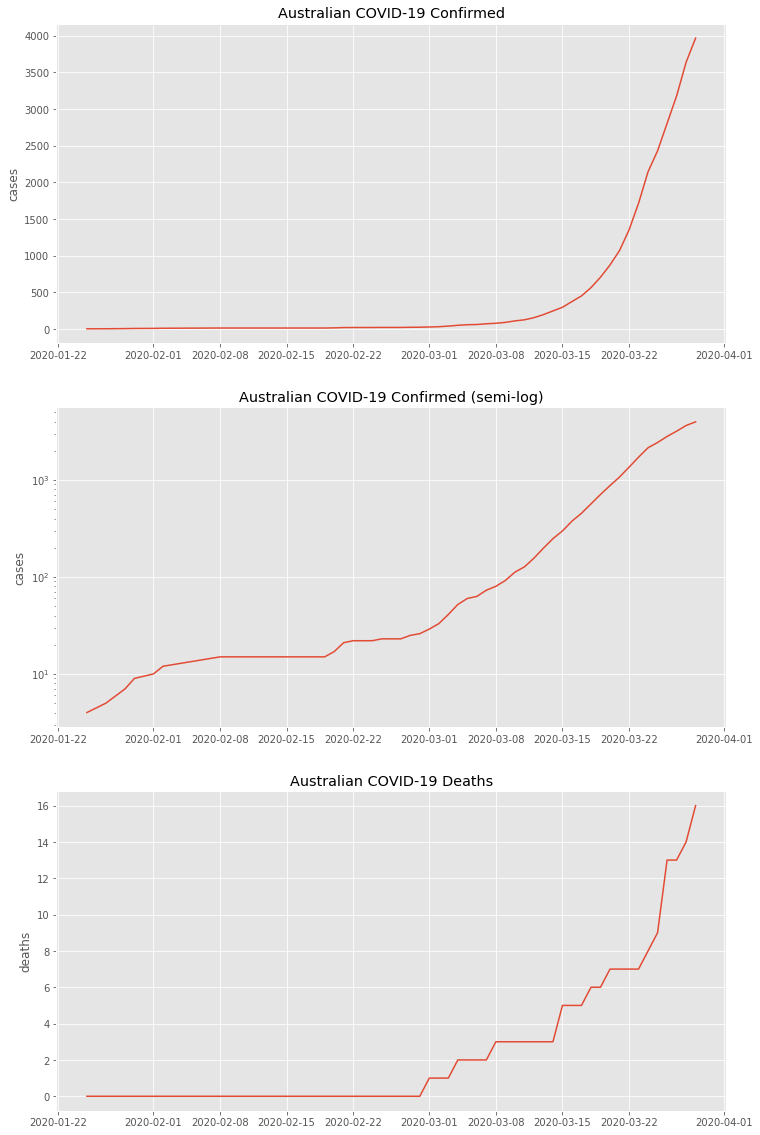

In [34]:
df = pd.read_csv('au_total.csv')
#df = df.iloc[:-1]
df.index = pd.DatetimeIndex(df.date.values, dayfirst=True)
df.drop('date', inplace=True, axis=1)
df['days'] = np.arange(0, df.shape[0])

# calculate % change (growth)
df['case_growth'] = df['confirmed'].pct_change() * 100

# calculate doubling time
# https://en.wikipedia.org/wiki/Doubling_time
df['case_dble_time'] = 70/df['case_growth']

# calculate % change (growth)
df['death_growth'] = df['deaths'].pct_change() * 100
# calculate doubling time
df['death_dble_time'] = 70/df['death_growth']


fig = plt.figure(figsize=(12, 20))

# Confirmed Cases
ax1 = fig.add_subplot(311)
ax1.plot(df.confirmed)
ax1.set_title('Australian COVID-19 Confirmed')
ax1.set_ylabel('cases')

# Confirmed (semi-log)
ax2 = fig.add_subplot(312)
ax2.plot(df.confirmed)
ax2.set_yscale('log')
ax2.set_ylabel('cases');
ax2.set_title('Australian COVID-19 Confirmed (semi-log)');

# Deaths
ax3 = fig.add_subplot(313)
ax3.plot(df.deaths)
ax3.set_ylabel('deaths');
ax3.set_title('Australian COVID-19 Deaths');

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, min_samples_leaf=3, random_state=17)

In [53]:
y = df.days.values
X = np.log(df.confirmed.values)
rf.fit(X.reshape(-1,1), y.reshape(-1,1))

/Users/sumedho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=17, verbose=0,
                      warm_start=False)

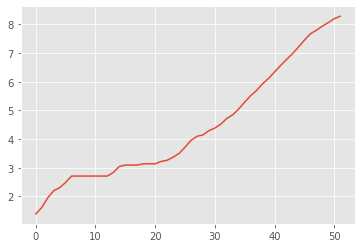

In [65]:
plt.plot(X)

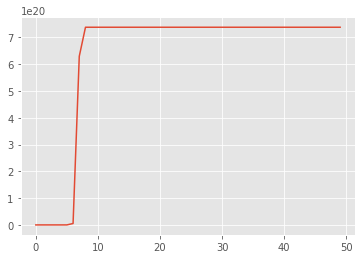

In [61]:
plt.plot(np.exp(rf.predict(np.arange(1, 51).reshape(-1,1))))

# Exponential Curve Fit

a: 0.8855293786558718 b: 0.16320930392695832 c: 3.0233978631833087e-13


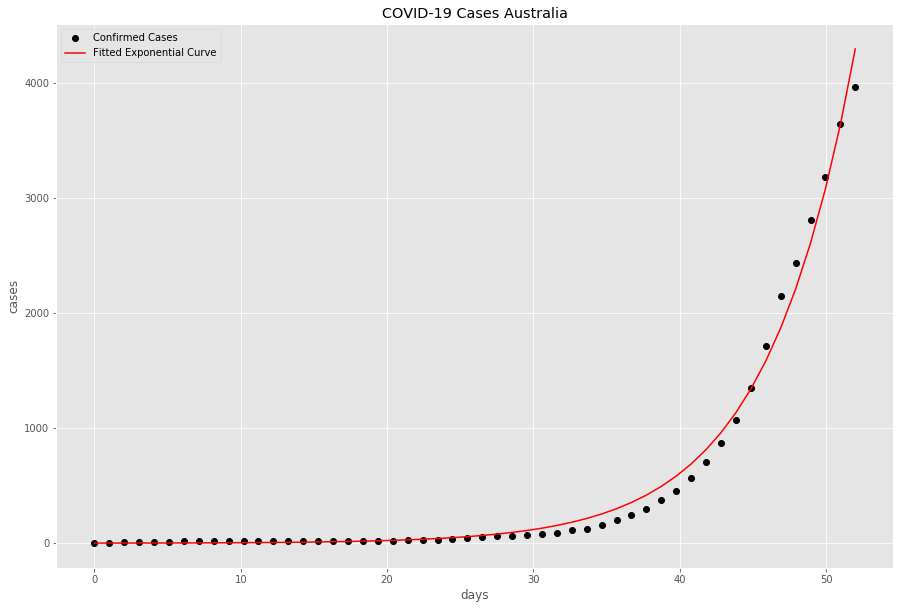

In [5]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(b * x) + c


x = np.linspace(0, df.shape[0], df.shape[0])
confirmed = df.confirmed.values
popt, pcov = curve_fit(func, x, confirmed, bounds=(0, [20., 1., 10.]))

print('a: {0} b: {1} c: {2}'.format(popt[0], popt[1], popt[2]))

fig = plt.figure(figsize=(15, 10))
plt.plot(x, confirmed, 'ko', label="Confirmed Cases")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Exponential Curve")
plt.title('COVID-19 Cases Australia')
plt.xlabel('days');
plt.ylabel('cases');
plt.legend();

# Future predictions

In [35]:
current_days = df.shape[0]
# find scale factor to match exactly 
# current days to max confirmed cases
scale_factor = 0
for i in range(0, 1000):
    scale_factor = scale_factor + 0.001
    result = func(current_days - scale_factor, *popt)
    if (result - df.confirmed.max()) < 0:
        break

day = 1 - scale_factor
print(day)
print('Current total: {0:,}'.format(df.confirmed.max()))
print('Predicted next day: {0:,}'.format(int(func(current_days + day, *popt))))
print('Predicted next three days: {0:,}'.format(int(func(current_days + 3 * day, *popt))))
print('Predicted next week (7 days): {0:,}'.format(int(func(current_days + 7 * day, *popt))))
print('Predicted in two weeks (14 days): {0:,}'.format(int(func(current_days + 14 * day, *popt))))

0.5139999999999996
Current total: 3,968
Predicted next day: 4,671
Predicted next three days: 5,524
Predicted next week (7 days): 7,727
Predicted in two weeks (14 days): 13,901


# Statsmodel Exponential Fit

In [8]:
import statsmodels.api as sm

df['log_confirmed'] = np.log(df.confirmed)

X = np.arange(0, df.shape[0])
X = sm.add_constant(X)
y = df.log_confirmed.values

model = sm.OLS(y, X)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     757.2
Date:                Sun, 29 Mar 2020   Prob (F-statistic):           7.31e-32
Time:                        16:41:04   Log-Likelihood:                -36.595
No. Observations:                  52   AIC:                             77.19
Df Residuals:                      50   BIC:                             81.09
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1951      0.136      8.764      0.0

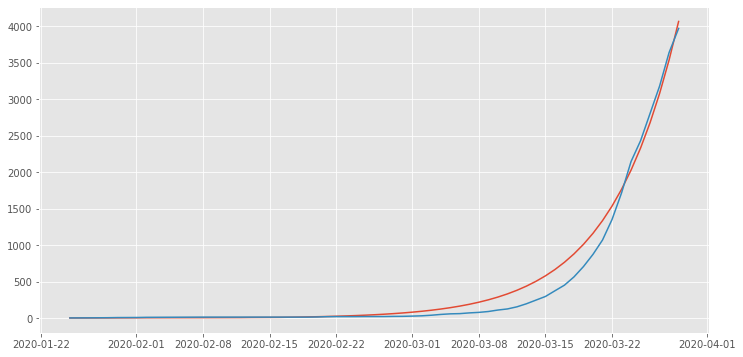

In [9]:
x0 = np.exp(1.2209)
b = np.exp(0.139)

result = x0 * np.power(b, np.arange(0, df.shape[0]))

df['pred'] = result

fig = plt.figure(figsize=(12, 6))
plt.plot(df.pred)
plt.plot(df.confirmed)

In [7]:
2100 * 1/100

21.0